## Сombine several images into a collage

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

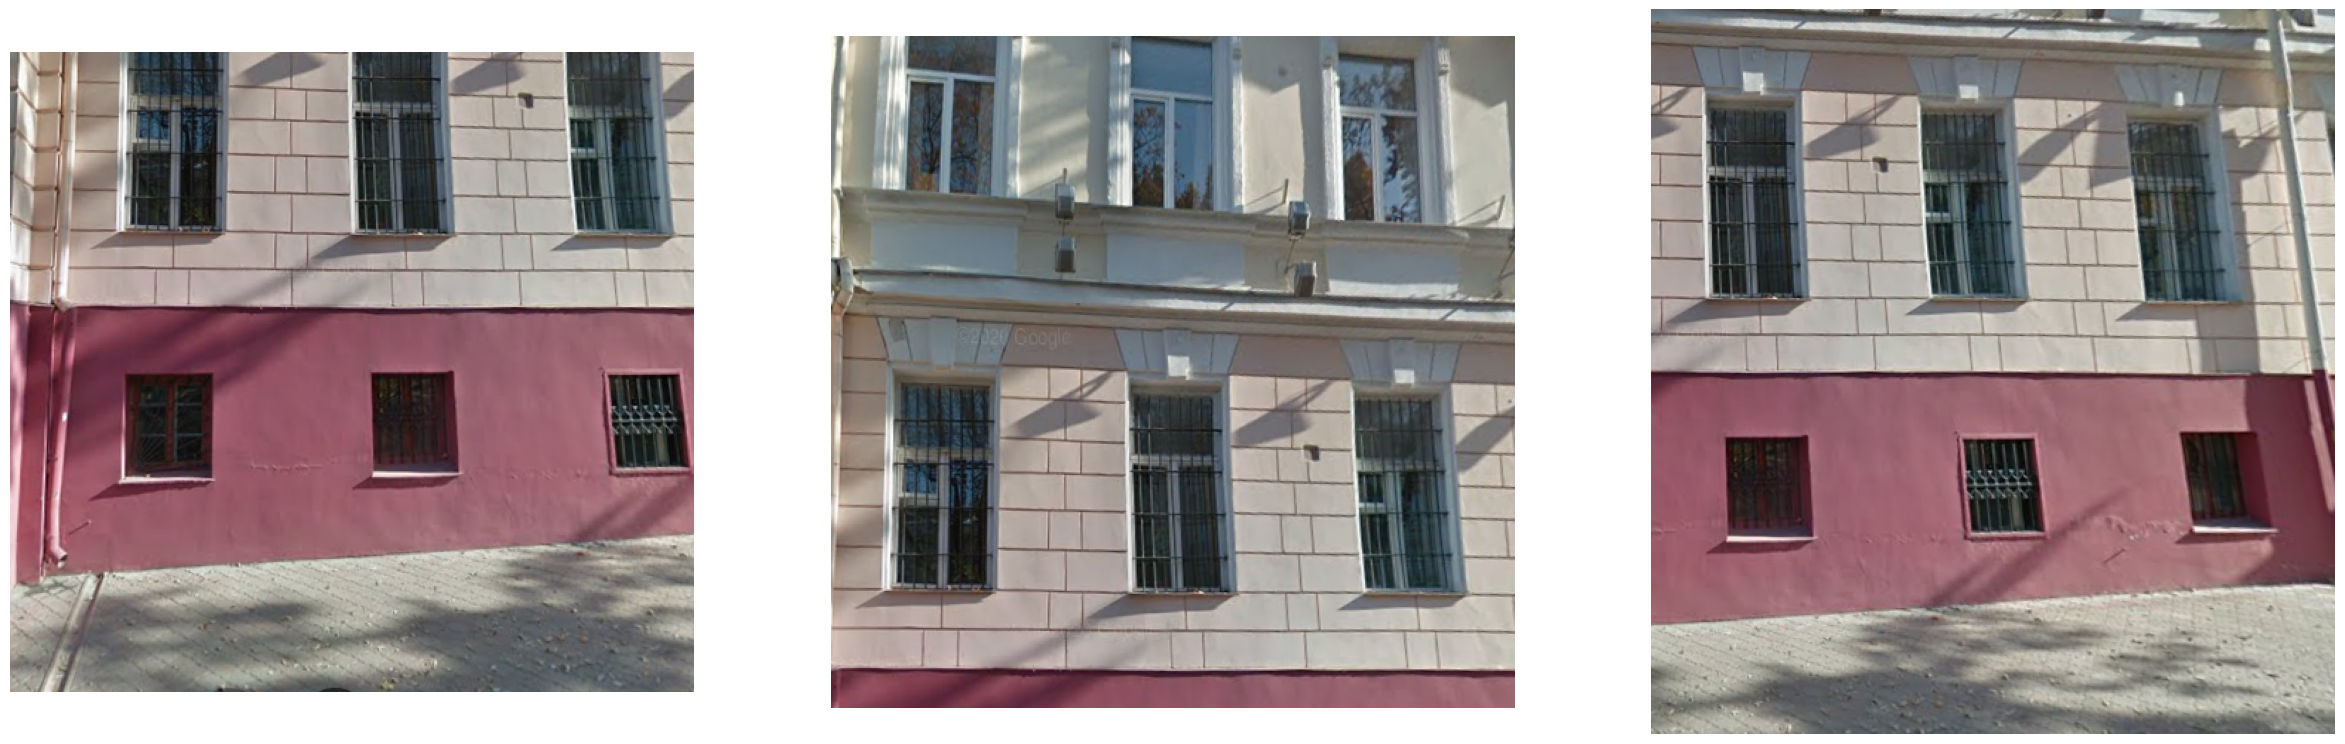

In [2]:
img1 = cv2.imread('imgs/img1_1.png')
img2 = cv2.imread('imgs/img1_2.png')
img3 = cv2.imread('imgs/img1_3.png')

plt.figure(figsize=(30, 10))
for i, img in enumerate([img1, img2, img3]):
    plt.subplot(1, 3, i+1)
    plt.imshow(img[..., ::-1])
    plt.axis('off')
plt.show()

In [3]:
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

In [4]:
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
kp3, des3 = sift.detectAndCompute(img3, None)

kp1_coords = np.array([x.pt for x in kp1])
kp2_coords = np.array([x.pt for x in kp2])
kp3_coords = np.array([x.pt for x in kp3])

In [5]:
kp1_coords.shape

(994, 2)

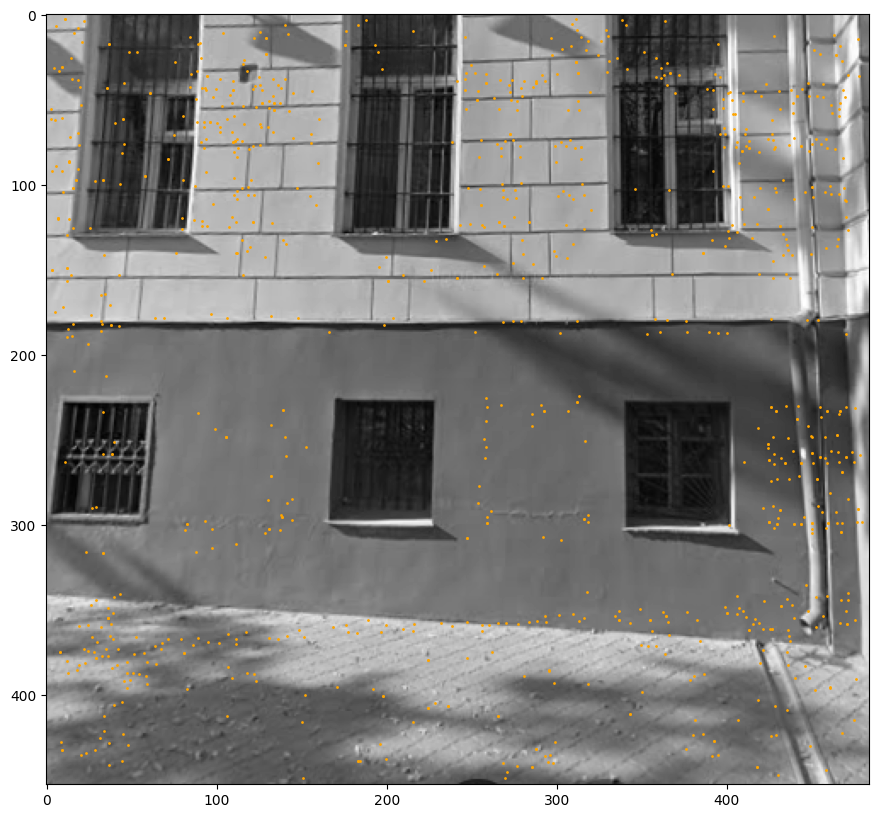

In [6]:
plt.figure(figsize=(20, 10))
plt.imshow(img1[..., ::-1], cmap='gray')
plt.scatter(*kp1_coords.T, s=1, c="orange")
plt.show()

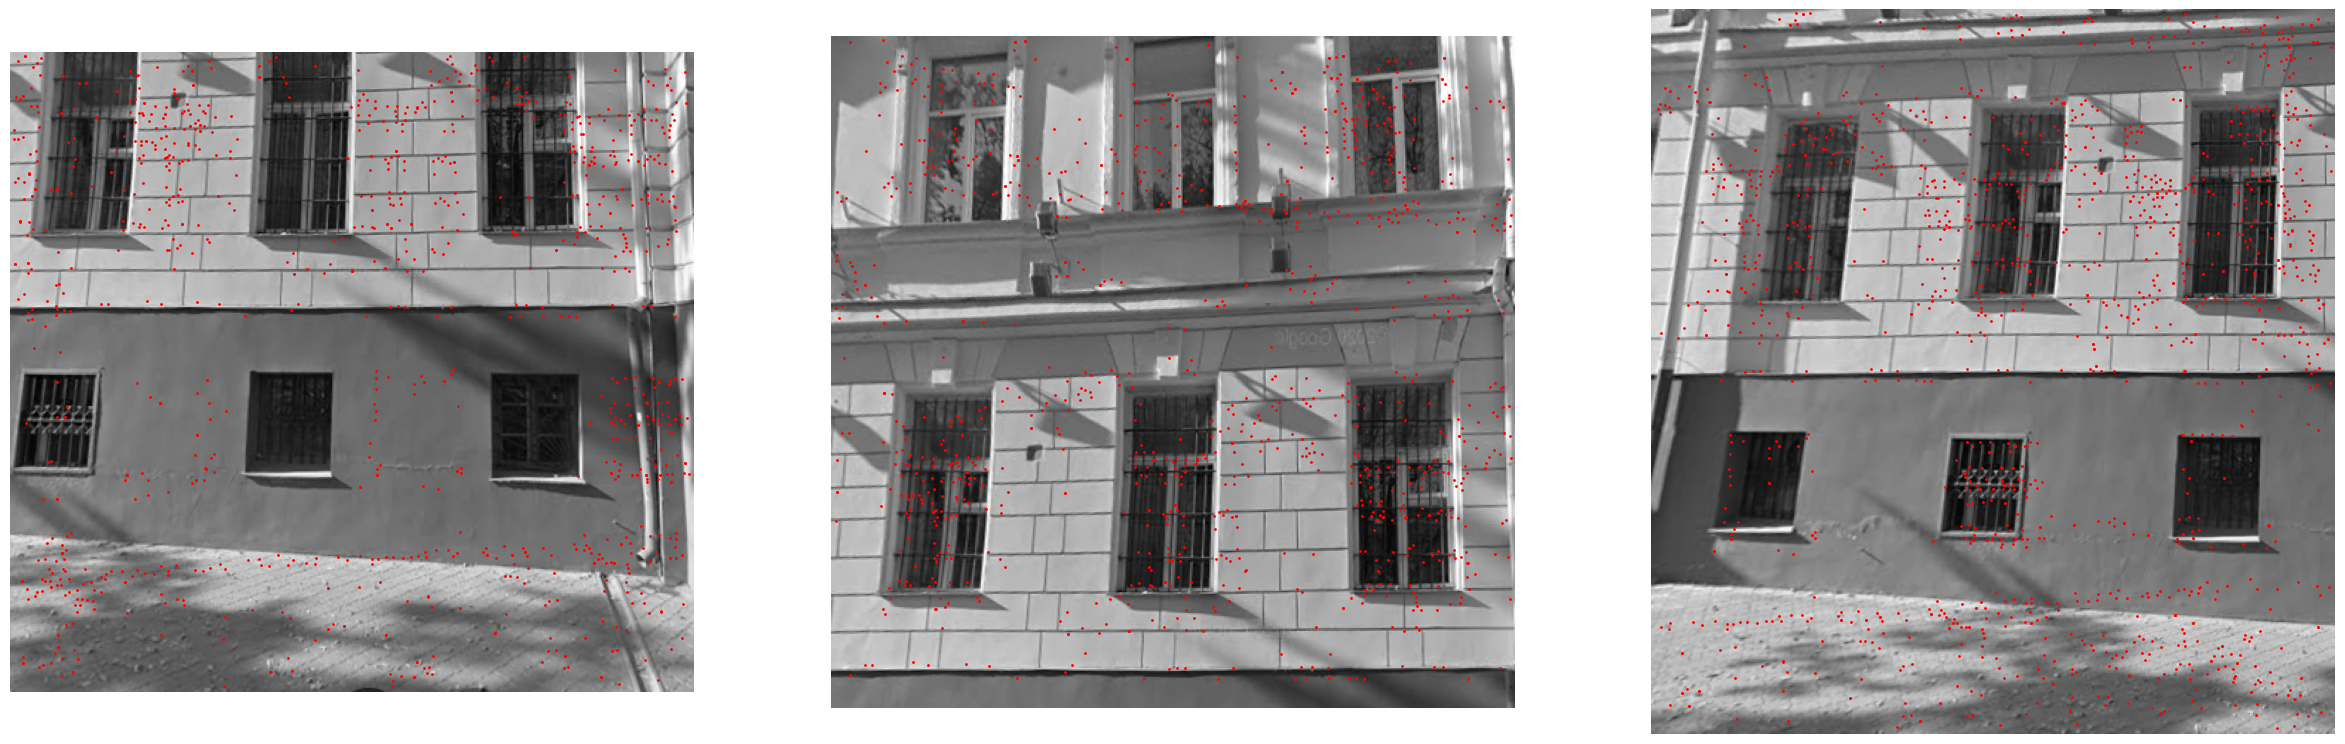

In [7]:
plt.figure(figsize=(30, 10))
for i, (img, kp_coords) in enumerate([(img1, kp1_coords), (img2, kp2_coords), (img3, kp3_coords)]):
    plt.subplot(1, 3, i+1)
    plt.imshow(img[..., ::-1], cmap='gray')
    plt.scatter(*kp_coords.T, s=1, c="red")
    plt.axis('off')
plt.show()

In [8]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

In [9]:
# store all the good matches as per Lowe's ratio test.
matches12 = flann.knnMatch(des1,des2,k=2)
good12 = []
for m,n in matches12:
    if m.distance < 0.7*n.distance:
        good12.append(m)

src_pts = np.float32([kp1[m.queryIdx].pt for m in good12]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good12]).reshape(-1,1,2)

M12, mask12 = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.)

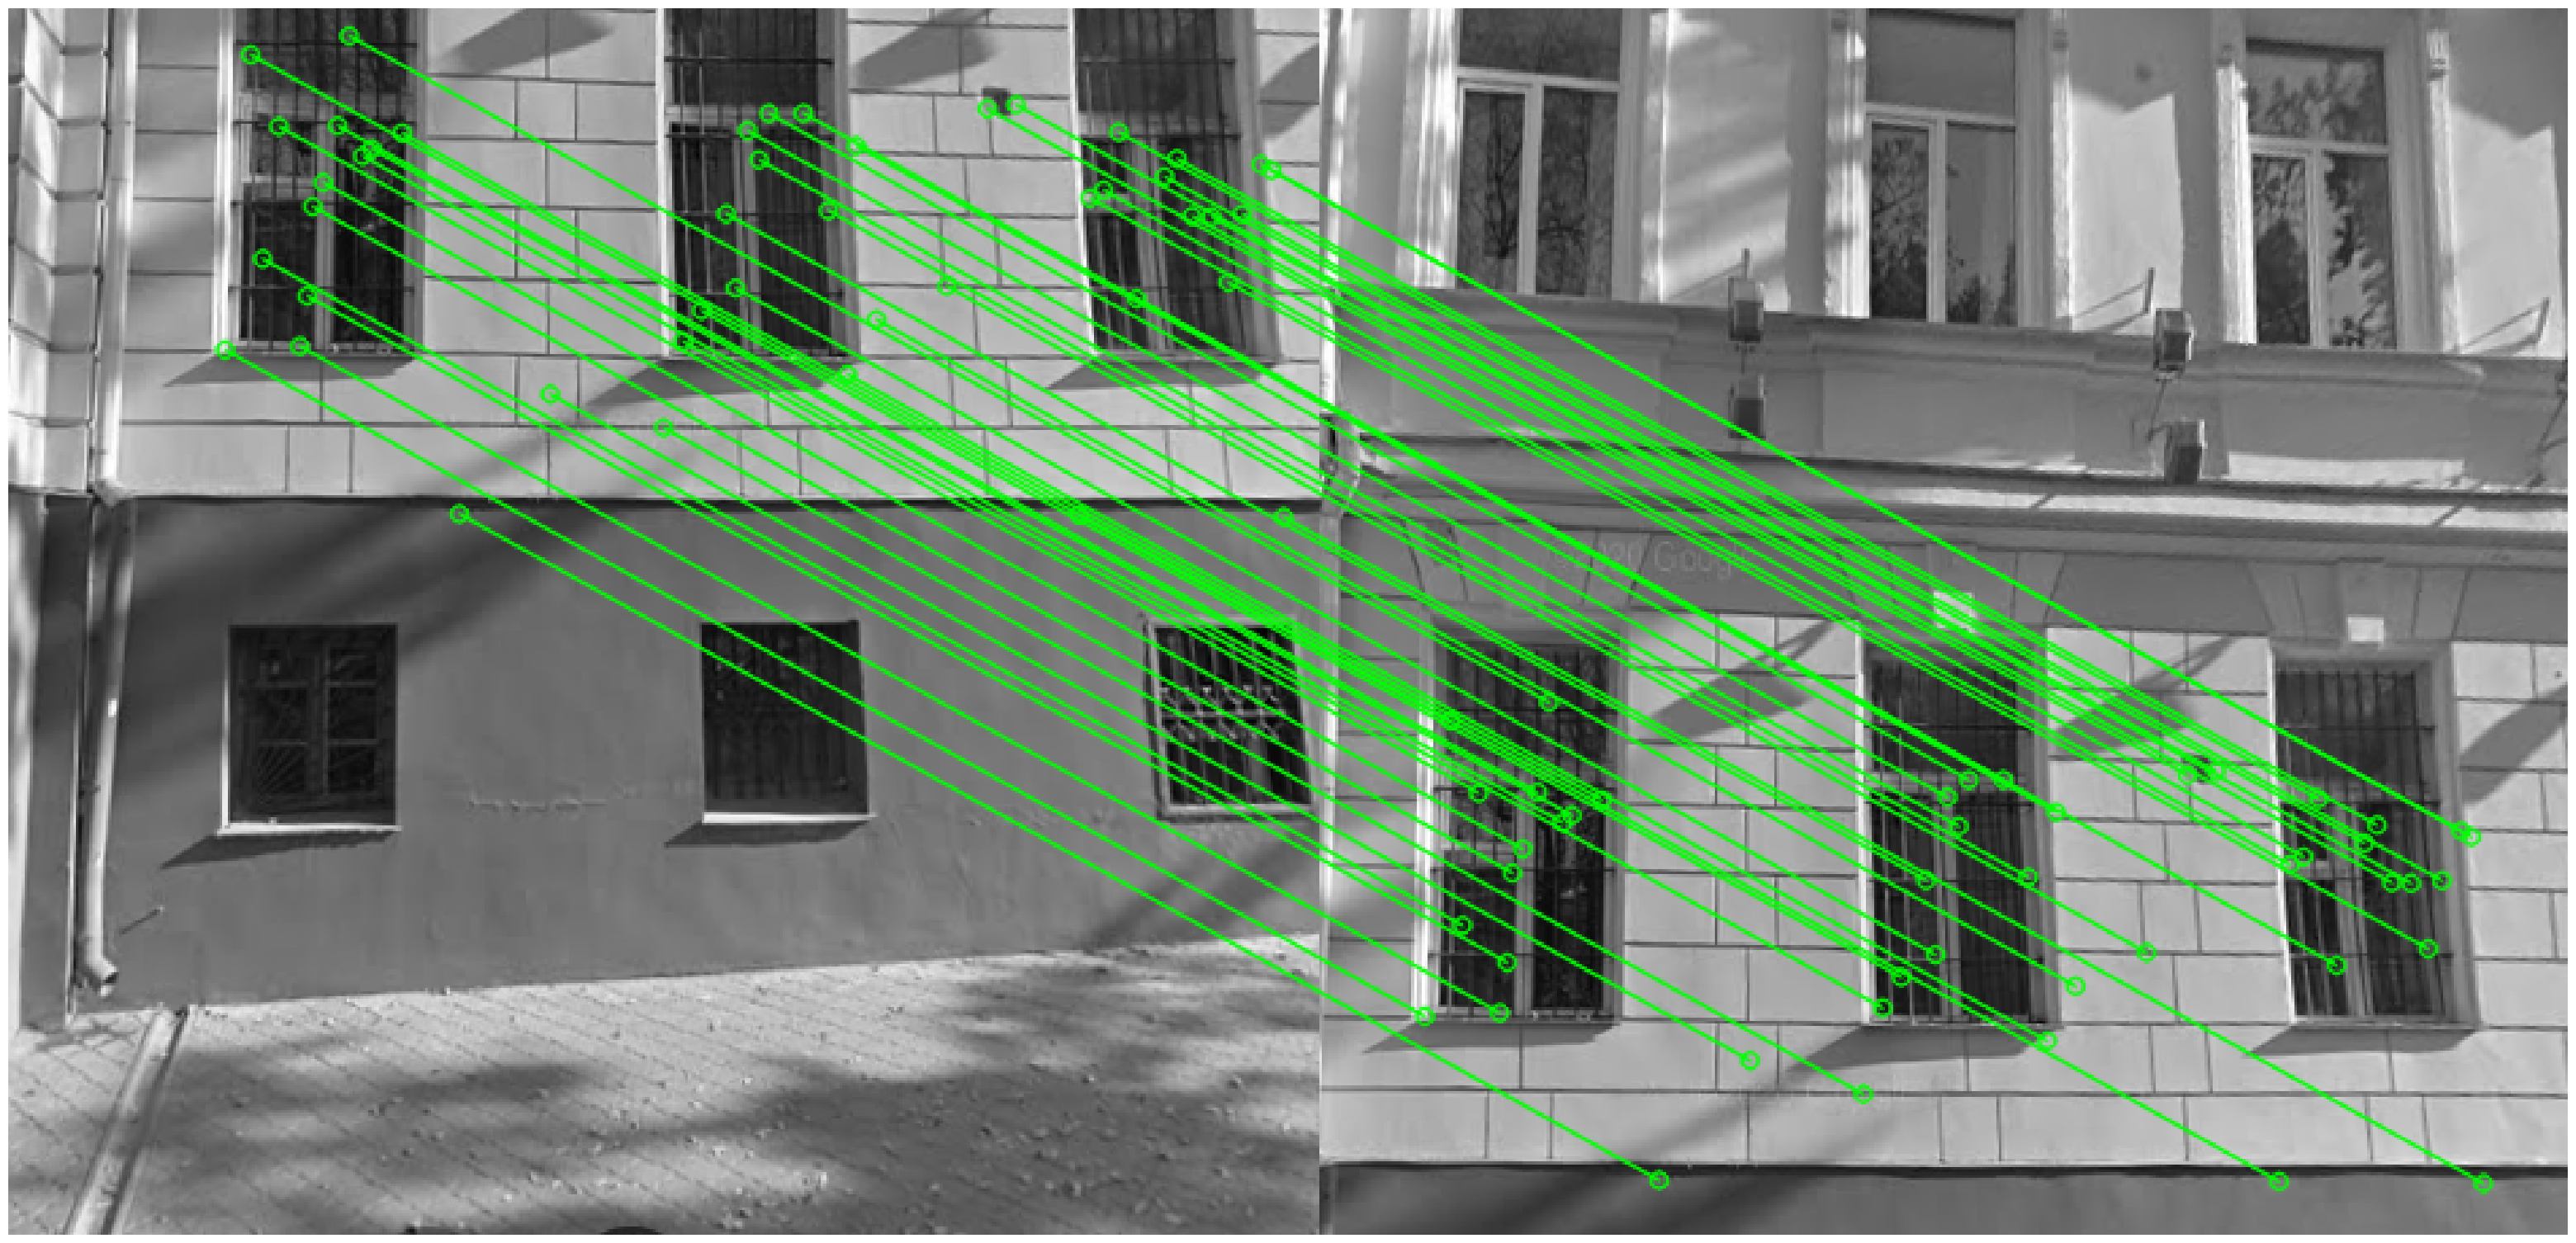

In [10]:
matchesMask = mask12.ravel().tolist()
draw_params = dict(matchColor = (0, 255, 0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask[::10], # draw only inliers
                   flags = 2)
img12 = cv2.drawMatches(img1,kp1,img2,kp2,good12[::10],None,**draw_params)
plt.figure(figsize=(40, 20))
plt.imshow(img12[..., ::-1])
plt.axis('off')
plt.show()

In [11]:
h, w = img1.shape
pts1 = np.array([
    [0, 0],
    [0, h-1],
    [w-1, h-1],
    [w-1, 0]
]).reshape((-1, 1, 2)).astype(np.float32)

h, w = img2.shape
pts2 = np.array([
    [0, 0],
    [0, h-1],
    [w-1, h-1],
    [w-1, 0]
]).reshape((-1, 1, 2)).astype(np.float32)

h, w = img3.shape
pts3 = np.array([
    [0, 0],
    [0, h-1],
    [w-1, h-1],
    [w-1, 0]
]).reshape((-1, 1, 2)).astype(np.float32)

In [12]:
matches32 = flann.knnMatch(des3,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good32 = []
for m,n in matches32:
    if m.distance < 0.7*n.distance:
        good32.append(m)
        
src_pts = np.float32([kp3[m.queryIdx].pt for m in good32]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good32]).reshape(-1,1,2)

M32, mask32 = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.)

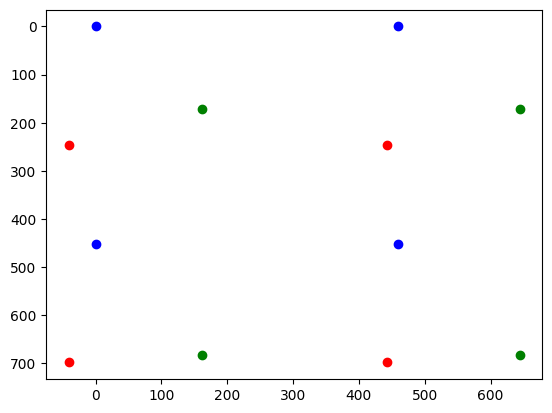

In [13]:
dst1 = cv2.perspectiveTransform(pts1, M12)
dst3 = cv2.perspectiveTransform(pts3, M32)

plt.scatter(*pts2.T, color='blue')
plt.scatter(*dst1.T, color='red')
plt.scatter(*dst3.T, color='green')
plt.gca().invert_yaxis()

In [14]:
all_pts = np.concatenate([dst1, pts2, dst3], axis=0)
x_min = int(all_pts[:, :, 0].min())
x_max = int(all_pts[:, :, 0].max())
y_min = int(all_pts[:, :, 1].min())
y_max = int(all_pts[:, :, 1].max())

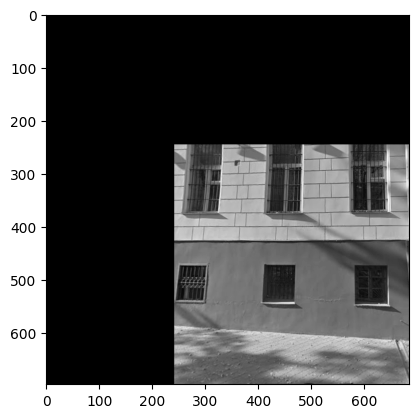

In [15]:
dst_img1 = cv2.warpPerspective(img1, M12, (x_max-x_min, y_max-y_min))
plt.imshow(dst_img1[..., ::-1], cmap='gray')
plt.show()

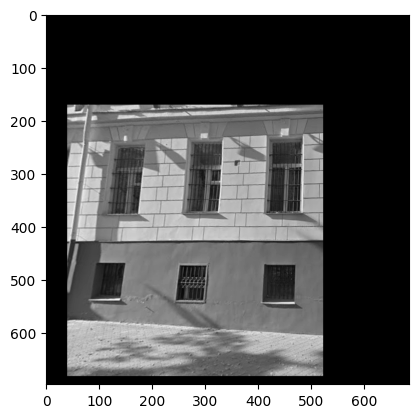

In [16]:
dst_img3 = cv2.warpPerspective(img3, M32, (x_max-x_min, y_max-y_min))
plt.imshow(dst_img3[..., ::-1], cmap='gray')
plt.show()

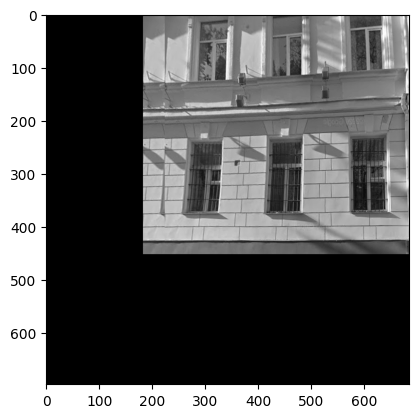

In [17]:
dst_img2 = np.zeros((y_max-y_min, x_max-x_min)).astype(int)
dst_img2[-y_min:-y_min+img2.shape[0], -x_min:-x_min+img2.shape[1]] = img2
dst_img2[:img2.shape[0], :img2.shape[1]] = img2
plt.imshow(dst_img2[..., ::-1], cmap='gray')
plt.show()

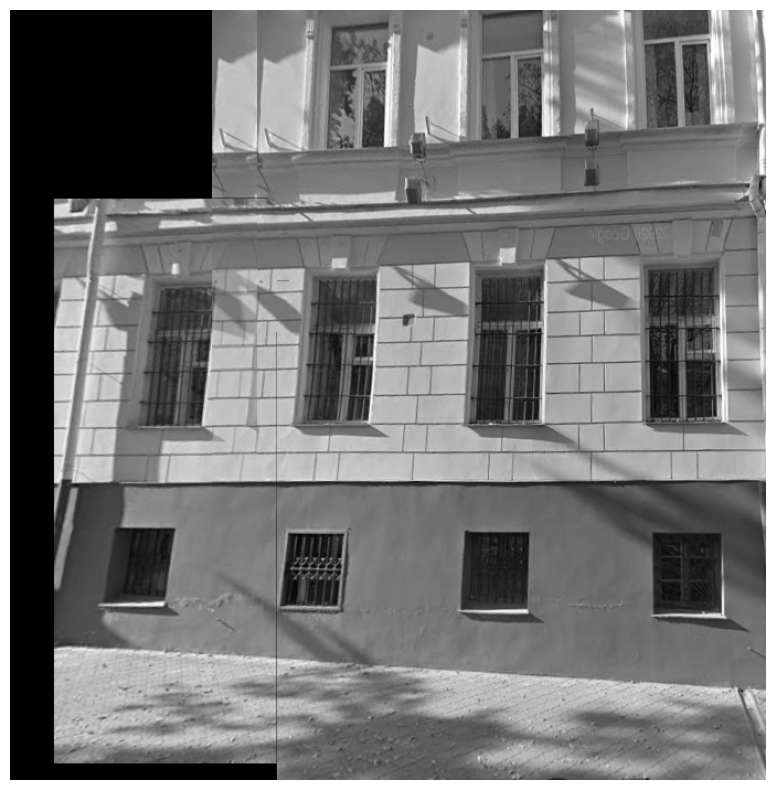

In [18]:
dst_img = np.mean([dst_img3, dst_img2, dst_img1], axis=0)

w1 = (dst_img1 > 0) + 1e-5
w2 = (dst_img2 > 0) + 1e-5
w3 = (dst_img3 > 0) + 1e-5

dst_img = (dst_img1 * w1 + dst_img2 * w2 + dst_img3 * w3) / (w1 + w2 + w3)

plt.figure(figsize=(20, 10))
plt.imshow(dst_img[..., ::-1]/255, cmap='gray')
plt.axis('off')
plt.show()

In [58]:
def split_2_img(img1_path, img2_path, fname):
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    
    sift = cv2.SIFT_create()
    
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    
    kp1_coords = np.array([x.pt for x in kp1])
    kp2_coords = np.array([x.pt for x in kp2])
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches12 = flann.knnMatch(des1,des2,k=2)
    good12 = []
    for m,n in matches12:
        if m.distance < 0.7*n.distance:
            good12.append(m)
            
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good12]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good12]).reshape(-1,1,2)
    
    M12, mask12 = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.)
    
    matchesMask = mask12.ravel().tolist()
    draw_params = dict(matchColor = (0, 255, 0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask[::10], # draw only inliers
                       flags = 2)
    img12 = cv2.drawMatches(img1,kp1,img2,kp2,good12[::10],None,**draw_params)

    h, w, _ = img1.shape  # height, width, number of image channels
    pts1 = np.array([
        [0, 0], 
        [0, h-1],
        [w-1, h-1],  # lower right corner
        [w-1, 0]
    ]).reshape((-1, 1, 2)).astype(np.float32)

    h, w, _ = img2.shape
    pts2 = np.array([
        [0, 0],
        [0, h-1],
        [w-1, h-1],
        [w-1, 0]
    ]).reshape((-1, 1, 2)).astype(np.float32)
    
    dst1 = cv2.perspectiveTransform(pts1, M12)
    
    all_pts = np.concatenate([dst1, pts2], axis=0)
    x_min = int(all_pts[:, :, 0].min())
    x_max = int(all_pts[:, :, 0].max())
    y_min = int(all_pts[:, :, 1].min())
    y_max = int(all_pts[:, :, 1].max())
    
    M12t = M12 @ np.array([
        [1, 0, -x_min],
        [0, 1, -y_min],
        [0, 0, 1]
    ])

    M22t = np.array([
        [1, 0, -x_min],
        [0, 1, -y_min],
        [0, 0, 1]
    ]).astype(np.float64)

    dst_img1t = cv2.warpPerspective(img1, M12t, (x_max-x_min, y_max-y_min))
    dst_img2t = cv2.warpPerspective(img2, M22t, (x_max-x_min, y_max-y_min))
    
    w1 = (dst_img1t > 0) + 1e-5
    w2 = (dst_img2t > 0) + 1e-5

    dst_img = (dst_img1t * w1 + dst_img2t * w2) / (w1 + w2)
    cv2.imwrite("imgs/" + fname, dst_img)

In [59]:
def split_multiple_img(img_paths, fname):
    """ The images in the list must be sorted so that each current image has points 
    in common with at least one of the previously processed images.
    """
    split_2_img(img_paths[0], img_paths[1], fname)
    for i in range(2, len(img_paths)):
        split_2_img("imgs/" + fname, img_paths[i], fname)
        
    result = cv2.imread('imgs/' + fname)
    #plt.figure(figsize=(20, 10))
    #plt.subplot(1, 3, i+1)
    plt.imshow(result[..., ::-1])
    plt.axis('off')
    plt.show()

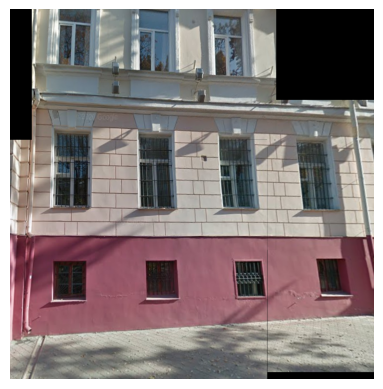

In [61]:
split_multiple_img(["imgs/img1_1.png", "imgs/img1_2.png", "imgs/img1_3.png"], "result1.png")

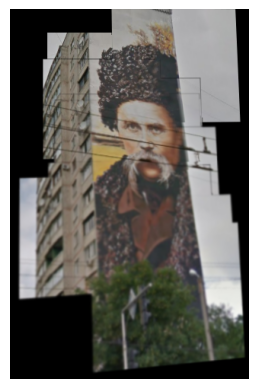

In [62]:
split_multiple_img(["imgs/img2_1.png", "imgs/img2_2.png", "imgs/img2_3.png", "imgs/img2_4.png", "imgs/img2_5.png", "imgs/img2_6.png", "imgs/img2_7.png", "imgs/img2_8.png", "imgs/img2_9.png", "imgs/img2_10.png", "imgs/img2_11.png", "imgs/img2_12.png", "imgs/img2_13.png", "imgs/img2_14.png"], "result2.png")